In [1]:
# Load basic packages
import numpy as np
import pandas as pd

import autograd.numpy as numpy
import autograd.numpy.random as npr

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection

# Useful for saving our models.
import pickle
print("Imported all!")

df = pd.read_csv('diabetes.csv')
df = df.dropna()
diabetes = df
print("Shape of the loaded dataset: {} rows and {} columns.".format(diabetes.shape[0], diabetes.shape[1]))
df.head()

Imported all!
Shape of the loaded dataset: 253680 rows and 22 columns.


,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,Myocardial,PhysActivity,Fruit,Vegetables,...,NotAbleToAffordDoctor,GeneralHealth,MentalHealth,PhysicalHealth,HardToClimbStairs,BiologicalSex,AgeBracket,EducationBracket,IncomeBracket,Zodiac
0,0,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,1,9,4,3,10
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,1,7,6,1,11
2,0,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,1,9,4,8,2
3,0,1,0,27,0,0,0,1,1,1,...,0,2,0,0,0,1,11,3,6,11
4,0,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,1,11,5,4,8


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Sample data
data = diabetes

# Define columns
categorical_cols = [17, 21]  # Indices of categorical columns (sex + zodiac sign)
# We are not going to touch the ordinal data anyhow, since it is already giving the appropriate weights to the model
# ordinal_cols = [18, 19, 20]  # Indices of ordinal columns (age, education, income)
continuous_cols = [3, 13, 14, 15]  # Indices of continuous columns (BMI, general health, mental health, physical health)

# One-Hot Encoding for categorical variables

# pass the numpy column to the data to make this transofrmantion happen
def categorical_to_ohe(data, col_idx):
    one_hot_encoded_data = []
    categorical_column = data[:, col_idx]
    
    # for col_idx in categorical_cols:
    unique_values = np.unique(categorical_column)
    for value in unique_values[:-1]:  # Exclude the last category to avoid the dummy variable trap
        one_hot_encoded_data.append((data[:, col_idx] == value).astype(int))
    
    return np.array(one_hot_encoded_data).T

# Normalization for continuous variables (using Min-Max scaling to scale between 0 and 1)
def normalize_continious_variables(data, col_idx):
    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(data[:, col_idx].reshape(-1, 1))
    return scaled

# Standardization for ordinal variables (using Standard scaling with mean 0 and STD of 1)
def standardize_ordinal_variables(data, col_idx):
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    scaled = scaler.fit_transform(data[:, col_idx].reshape(-1, 1))
    return scaled


ready_to_use_columns_p1 = [1, 2]
# Scale continious variables
normalized_BMI = standardize_ordinal_variables(data, 3)
ready_to_use_columns_p2 = [i for i in range(4, 13)]
normalized_general_health = standardize_ordinal_variables(data, 13)
normalized_mental_health = standardize_ordinal_variables(data, 14)
normalized_physical_health = standardize_ordinal_variables(data, 15)

# transform the sex column into OHE (one column only - no dummy variable trap)
sex_one_hot_encoded = categorical_to_ohe(data, 17)
# Let's now scale the ordinal columns (bracket values)
normalized_age = standardize_ordinal_variables(data, 18)
normalized_education = standardize_ordinal_variables(data, 19)
normalized_income = standardize_ordinal_variables(data, 20)

# We are not using this one for the models, as it is unnecessary and adds a lot of dimensions
zodiac_one_hot_encoded = categorical_to_ohe(data, 21)


# Now, combine all the columns back together
processed_data = np.concatenate((
    # 1 and 2 are as is
    data[:, ready_to_use_columns_p1],
    # BMI is normalized
    normalized_BMI,
    # [4-13] are as is
    data[:, ready_to_use_columns_p2],
    # health predictors are normalized
    normalized_general_health, 
    normalized_mental_health, 
    normalized_physical_health,
    # 16 is as is
    data[:, 16].reshape(-1, 1),
    # 17 is OHE
    sex_one_hot_encoded,
    # age, education, and income brackets are normalized
    normalized_age,
    normalized_education, 
    normalized_income,
    # zodiac_one_hot_encoded
), axis=1)

# column names
column_names = [
    "High blood pressure", 
    "High cholesterol", 
    "Body Mass Index", 
    "Smoker", 
    "Stroke", 
    "Myocardial issues", 
    "Physically active", 
    "Eats fruit", 
    "Eats vegetables", 
    "Heavy Drinker", 
    "Has healthcare", 
    "Cannot Afford Doctor", 
    "General health", 
    "Mental health", 
    "Physical health", 
    "Hard to climb stairs", 
    "Biological sex", 
    "Age bracket", 
    "Education bracket", 
    "Income bracket"
    # "Zodiac sign"
]

# let's check that our predictor names correspond properly
print(processed_data.shape[1] == len(column_names))

idx_to_predictor = {}
predictor_to_idx = {}

for idx, predictor in enumerate(column_names):
    idx_to_predictor[idx] = column_names[idx]
    predictor_to_idx[predictor] = idx

y = diabetes[:, 0]  # the outcome is in the first column
X = processed_data
if X.shape[0] == y.shape[0]:
    print("Column numbers match! Data is ready to be used!")
    
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.2, random_state=21) # 0.2 is 20% test data.

True
Column numbers match! Data is ready to be used!


# Question 1: Building a perceptron

Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.80      0.85     43635
           1       0.29      0.51      0.37      7101

    accuracy                           0.76     50736
   macro avg       0.60      0.66      0.61     50736
weighted avg       0.82      0.76      0.78     50736



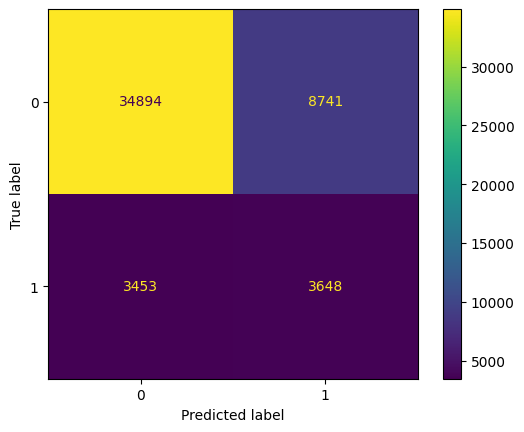

In [3]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

perceptron = Perceptron(tol=1e-3, random_state=0, shuffle=True)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)

report = classification_report(y_test, y_pred)
print("Classification Report:\n\n", report)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=perceptron.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=perceptron.classes_)
disp.plot()

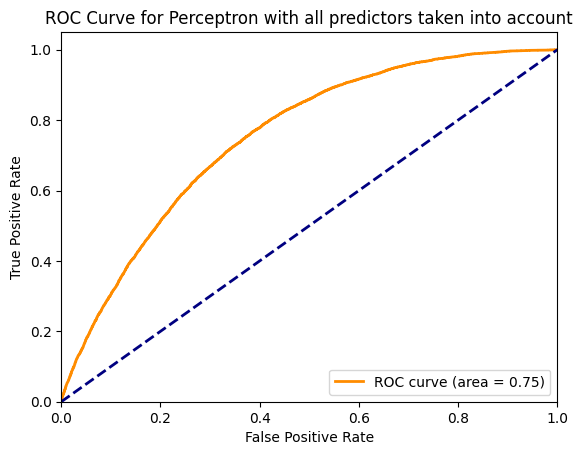

AUC score of the model:  0.7517936337601805


In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

decision_values = perceptron.decision_function(X_test)
predicted_probabilities = (decision_values - decision_values.min()) / (decision_values.max() - decision_values.min())
true_labels = y_test
auc_score_full_model = roc_auc_score(true_labels, predicted_probabilities)

def graph_auc_curve_log_reg(model, predicted_probabilities, true_labels, title="all predictors taken into account"):
    # calculate false positive rates, true positive rates, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    # calculate the roc_auc_score
    auc_score = roc_auc_score(true_labels, predicted_probabilities)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC Curve for Perceptron with {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

graph_auc_curve_log_reg(perceptron, predicted_probabilities, true_labels)
print("AUC score of the model: ", auc_score_full_model)

# --------------------------------------------------------------------------

# Question 2: Building a feedforward network with one layer

In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
# , dtype=torch.long
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create a custom dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_batch_sizes = [32, 64, 128, 256, 512]
test_batch_size = 1024

# create 5 different train loaders
train_loaders = []
for train_batch_size in train_batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    num_batches = len(train_loader)
    print("Added new train loader with {} batches".format(num_batches))
    train_loaders.append(train_loader)

test_loader = DataLoader(train_dataset, batch_size=test_batch_size, shuffle=True)

Added new train loader with 6342 batches
Added new train loader with 3171 batches
Added new train loader with 1586 batches
Added new train loader with 793 batches
Added new train loader with 397 batches


In [38]:
# BRAND NEW APPROACH HERE:

D = X_train.shape[1] # input dimensions --> number of columns
C = 2  # num_classes --> classification problem requires number of classes we want to classify into
H = 20  # num_hidden_units --> hyperparmater (arbitrary, but usually defined by C), ten features in one hidden layer

model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)


learning_rate = 1e-3
lambda_l2 = 1e-1 # coefficient for the L2 regularizer. You should play with its value to see the effect of regularization

# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [43]:
D = X_train.shape[1] # input dimensions --> number of columns
C = 2  # num_classes --> classification problem requires number of classes we want to classify into
H = 20  # num_hidden_units --> hyperparmater (arbitrary, but usually defined by C), ten features in one hidden layer

model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)

learning_rate = 1e-3
lambda_l2 = 1e-1 # coefficient for the L2 regularizer. You should play with its value to see the effect of regularization

# we use cross entropy loss for our classification task
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# Training loop: with 100 epochs
n_epochs = 100
for epoch in range(n_epochs):
    # model.train()
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            y_pred = model(X_batch)
            print(y_pred, len(y_pred))
            
            loss = loss_function(y_pred, y_batch).float()
            epoch_loss += loss.item()
            
            batch_acc = accuracy(y_pred, y_batch)
            epoch_acc += batch_acc

            score, predicted = torch.max(y_pred, 1)
            acc = (y_train_tensor == predicted).sum() / len(y_train)
            print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, loss.item(), acc))
            display.clear_output(wait=True)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    # Forward pass over the model to get the logits
    # only available with a small dataset, use the batch gradient descent with bigger datasets
    
    y_pred = model(X_train_tensor) #1
    y_labels = y_batch.to(y_pred.dtype)
    
    # print(X_train_tensor.dtype)
    # print(y_pred.dtype)
    
    # Compute the loss and accuracy
    # loss is also a tensor!!
    loss = criterion(y_pred, y_train_tensor) #2

    # # 2 dimensions in the prediction and 1 in the ground truth
    # print(y_pred, y_train_tensor)
    # break
    score, predicted = torch.max(y_pred, 1)
    acc = (y_train_tensor == predicted).sum() / len(y_train)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, loss.item(), acc))
    display.clear_output(wait=True)
    
    # reset (zero) the gradients before running the backward pass over the model
    # we need to do this because the gradients get accumulated at the same place across iterations
    optimizer.zero_grad() #3
    
    # Backward pass to compute the gradient of loss w.r.epoch our learnable params (weights and biases)
    loss.backward() #4
    
    # Update params
    optimizer.step() #5

tensor([[ 0.0857,  0.2626],
        [-0.0732,  0.1949],
        [-0.0179,  0.3994],
        ...,
        [ 0.0933,  0.1814],
        [-0.0901,  0.2779],
        [-0.2346,  0.3824]], grad_fn=<AddmmBackward0>) 512


RuntimeError: expected scalar type Long but found Float

In [ ]:


class FlexibleFC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden_layers, hidden_size, output_size, activation=''):
        super(FlexibleFC2Layer, self).__init__()
        self.input_size = input_size
        self.n_hidden_layers = n_hidden_layers
        self.hidden_size = hidden_size

        if activation == 'relu':
            self.activation = nn.ReLU()  
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            # Activation function not implemented, using default Identity
            self.activation = nn.Identity()

        layers = []
        # Add input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(self.activation)

        # Add hidden layers
        for _ in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(self.activation)

        # Add output layer
        layers.append(nn.Linear(hidden_size, output_size))
        # Getting rid of the overflow and underflow issues by taking log of the softmax
        # We don'epoch need to do this if we are using Cross Entropy loss as a function
        # layers.append(nn.LogSoftmax(dim=1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

# architecture hyperparameters 
D = X_train.shape[1]  # input dimensions


# Define training hyperparameters
learning_rate = 1e-4
lambda_l2 = 1e-2

n_hidden_units = [5, 15, 45]
activation_functions = ['relu', 'sigmoid', 'identity']
one_layer_models = []

for units_per_model in n_hidden_units:
    for activation_func in activation_functions:
        one_layer_model = FlexibleFC2Layer(input_size=D, n_hidden_layers=1, hidden_size=units_per_model, output_size=1, activation=activation_func)
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(one_layer_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
        one_layer_models.append({"model": one_layer_model, "loss_function": loss_function, "optimizer": optimizer})


def train(model, loss_function, optimizer, train_loader, num_epochs=100):
    num_batches = len(train_loader)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_acc = 0.0
        model.train()
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            y_pred = model(X_batch)
            
            y_batch = y_batch.to(y_pred.dtype)
            
            loss = loss_function(y_pred, y_batch)
            epoch_loss += loss.item()
            
            batch_acc = accuracy(y_pred, y_batch)
            epoch_acc += batch_acc
        
            loss.backward()
            optimizer.step()
    
        avg_loss = epoch_loss / num_batches
        avg_acc = epoch_acc / num_batches
        
        # Log every 10 epochs
        if epoch % 10 == 0:
            print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, avg_loss, avg_acc))

def accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

for idx, model_info in enumerate(one_layer_models):
    model = model_info["model"]
    loss_function = model_info["loss_function"]
    optimizer = model_info["optimizer"]
    
    print("\nTraining #{} starts".format(idx))
    train(model, loss_function, optimizer, train_loader)
    print("\n\n\n\n")
    
# def train(model, loss_function, optimizer, inputs, labels, train_loader, num_epochs=100):
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         epoch_acc = 0.0
#         model.train()
#         optimizer.zero_grad()
        
#         for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
#             # Forward pass over the model to get the logits
#             y_pred = model(X_batch)
            
#             # Compute the loss
#             loss = loss_function(y_pred, y_batch)
#             epoch_loss += loss.item()
            
#             # Compute accuracy
#             _, predicted = torch.max(y_pred, 1)
#             batch_acc = (y_batch == predicted).sum().item() / len(y_batch)
#             epoch_acc += batch_acc
            
#             # Reset gradients
#             optimizer.zero_grad()
            
#             # Backward pass
#             loss.backward()
            
#             # Update params
#             optimizer.step()
    
#         # Calculate average loss and accuracy for the epoch
#         avg_loss = epoch_loss / num_batches
#         avg_acc = epoch_acc / num_batches
        
#         print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, avg_loss, avg_acc))

# Define training function
def train_one_layer_model(model, loss_function, optimizer, inputs, labels, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss = loss.item()
        if (epoch + 1) % 100 == 0:
           print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


# def train(epoch, model, optimizer, loss_function, train_loader, verbose=False):
#     model.train()
#     epoch_loss = 0
#     losses = []
#     for batch_idx, (data, target) in enumerate(train_loader):
        
#         optimizer.zero_grad()
#         output = model(data)
#         loss = loss_function(output, target)
#         loss.backward()
#         optimizer.step()
        
#         if batch_idx % 100 == 0:
#             losses.append(loss.detach())
#             if verbose :
#                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                     epoch, batch_idx * len(data), len(train_loader.dataset),
#                     100. * batch_idx / len(train_loader), loss.item()))
#     return losses

# def test(model, verbose=False):
#     model.eval()
#     accuracy_list = []
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             # permute pixels
#             data = data.view(-1, 28*28)
#             data = data[:, perm]
#             data = data.view(-1, 1, 28, 28)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
#             pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
#             correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

#         test_loss /= len(test_loader.dataset)
#         accuracy = 100. * correct / len(test_loader.dataset)
#         accuracy_list.append(accuracy) 
#         if verbose :
#             print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#                 test_loss, correct, len(test_loader.dataset),
#                 accuracy))
#     return test_loss

In [ ]:
# architecture hyperparameters 
D = X_train.shape[1]  # input dimensions
H = 10  # number of hidden units

# Define training hyperparameters
learning_rate = 1e-4
lambda_l2 = 1e-2

n_layers = [1, 3, 5]
n_units = [5, 10, 15]
activation_functions = ['relu', 'sigmoid', 'identity']
auc_scores = {}

# model = nn.Sequential(
#     nn.Linear(D, H),
#     # nn.ReLU(),
#     nn.Linear(H, 1)
#     # nn.Sigmoid()  # Sigmoid activation function for binary classification
# )

# loss function == Cross Entropy Loss for binary classification
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor.view(-1, 1))  # Ensure y_train_tensor has the right shape
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    outputs = model(X_test_tensor)
    auc_score = roc_auc_score(y_test_tensor.numpy(), outputs.numpy())
    print("AUC Score:", auc_score)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define different configurations of hidden layers and activation functions
hidden_layer_sizes = [(10,), (5, 5), (3, 3, 3)]
activation_functions = ['relu', 'logistic', 'identity']
auc_scores = {}

# Go over different configurations
for hidden_layer_size in hidden_layer_sizes:
    for activation_function in activation_functions:
        clf = MLPClassifier(hidden_layer_sizes=hidden_layer_size, activation=activation_function, random_state=7)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        auc = roc_auc_score(y_test, y_pred)
        auc_scores[(hidden_layer_size, activation_function)] = auc


for config, auc in auc_scores.items():
    print("Configuration:", config, "- AUC Score:", auc)